# Plot timelines of ROH sharing
Plot individuals against their estimated age.
Input: Post-processed .csvs (pandas dfs) with individual ROH statistics and meta information (in particular age)

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as clb
import matplotlib.colors as cls
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap

import socket
import os as os
import sys as sys
import multiprocessing as mp

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

### To do lowess smoothing
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

### Additional Imports
sys.path.append("./PackagesSupport/")
from sqrt_scale import SquareRootScale # Import Matplotlib sqrt scale

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Definie Plotting Function

In [95]:
def plot_scatter_by_color(ax, age, roh, colors, labels, s):
    """Split up df per color, used to create legend
    (based on "clst" column)"""
    
    for c in pd.unique(colors):
        idx = (colors == c)
        ax.scatter(age[idx], roh[idx], c=c, edgecolor="k", s=s, 
                   label=labels[idx][0], zorder=1)


def plot_lowess_smoothing(df, cm=4, fs=14, fsl=10, tot_l=3539.39,
                          figsize=(14,6), title="", dpi=300, savepath="",
                          lowess=False, xlim=[], ylim=[], s=40, frac=2/3, cust_c=True):
    """Plot Lowess Smoothing of ROH vrs Age.
    df: Which Dataframe to use [standard pp format]
    cm: Length of blocks to plot
    savepath: If given save figure to there
    tot_l: Total length of accessible Chromosome [in cM]
    frac: Fraction Parameter to use for Lowess Smoothing"""
    
    ### Extract what to plot from dataframe
    df = df.sort_values(by="age", ascending=False) # Sort by age from old to young
    age,roh,labels = df["age"].values, df[f"sum_roh>{cm}"].values+0.1, df["clst"].values
    c = "b" 
    if cust_c==True:
        c = df["color"].values

    plt.figure(figsize=figsize)
    ax = plt.gca()
    
    plot_scatter_by_color(ax, age, roh, colors=c, labels=labels, s=s)
    
    if lowess:
        z = lowess_sqrt(age, roh, frac=frac)
        plt.plot(z[:,0], z[:,1], "k-", label=r"Lowess Smoothing ($\sqrt{x}$)", 
                 lw=2.5, zorder=0)

    ### Do the horizontal Lines
    ticks = [tot_l/16, tot_l/64]
    if len(xlim)>0:
        ax.set_xlim(xlim)
    if len(ylim)>0:
        ax.set_ylim(ylim)
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yscale('squareroot')
    ax2.set_yticks(ticks)
    ax2.set_yticklabels(["1st C.", "2nd C."])
    for t in ticks:
        ax.axhline(t, color="gray", lw=0.5, ls="--")
    ax2.tick_params(axis='y', direction='in', labelsize=fsl, pad=5)

    ax.set_xlabel("Age BP [years]", fontsize=fs)
    ax.set_ylabel(f"Sum ROH >{cm} cM [cM]", fontsize=fs)

    ax.invert_xaxis()
    ax.set_yscale('squareroot')
    #plt.ylim([0, 800])

    ax.legend(loc="upper right", fontsize=fsl)
    if len(title)>0:
        ax.set_title(title, fontsize=fs)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=dpi)
        print(f"Saved to {savepath}")
    plt.show()
    
def lowess_sqrt(x, y, frac=2/3):
    """Do a Lowess fitting on the sqrt.
    frac: parameter for lowess smoothing"""
    y=np.sqrt(y)
    z = lowess(y, x, frac=frac)
    z[:,1]=z[:,1]**2
    return z

####################################################
##### Helper Functions to split up Dataframes

def extract_df_geo(df, lat0, lat1, lon0, lon1):
    """Extract Dataframe df from Sub Data frame based on coordinates
    lat0,lat1: Min and Max Lat. Equ. for lon0,lon1"""
    lat_okay = (df["lat"]>lat0) & (df["lat"]<lat1)
    lon_okay = (df["lon"]>lon0) & (df["lon"]<lon1)
    df_s = df[lat_okay & lon_okay]
    return df_s

def extract_df_age(df, age0, age1=1e6):
    """Extract Dataframe based on age.
    df: Input Dataframe; age0 and age1 min and max age"""
    age_okay = (df["age"]>=age0) & (df["age"]<=age1)
    df = df[age_okay]
    return df

def give_df_clsts(df, search=[], col="pop"):
    """Return sub dataframe within df
    where in col one of search strings (list of string)"""
    idx = df[col].str.contains('|'.join(search)) # Find
    return df[idx]

def extract_sub_df_geo_kw(df, lat0, lat1, lon0, lon1, keywords=[]):
    """Extract Dataframe df from Sub Data frame based on coordinates
    AND from keywords
    lat0,lat1: Min and Max Lat. Equ. for lon0,lon1"""
    df1 = extract_df_geo(df, lat0, lat1, lon0, lon1).copy()  # Make a new Copy. America
    df2 = give_df_clsts(df_e, search=keywords) 
    df_m = pd.concat([df1, df2]).drop_duplicates().reset_index(drop=True)
    print(f"Found {len(df_m)} Individuals; {len(df1)} from Geography")
    return df_m

# Plot Roman Data (Antonio 19)

In [3]:
def pre_process_roman_df(df, age_error=0):
    """Preprocess and return roman df and adds colors"""
    color_dict = {"Medieval/EarlyModern":"yellow", "Imperial":"red", "Iron/Republic":"magenta", "LateAntiquity":"orange", 
              "Copper Age":"aquamarine", "Neolithic":"dodgerblue", "Mesolithic":"purple", "(not included in analyses)":"gray"}
    df["color"] = df["clst"].map(color_dict)
    if age_error>0:
        df["age"]+= np.random.random(len(df))*age_error - age_error/2
    return df

Saved to ./figures/manuscript/supplement/timelines/antonio.pdf


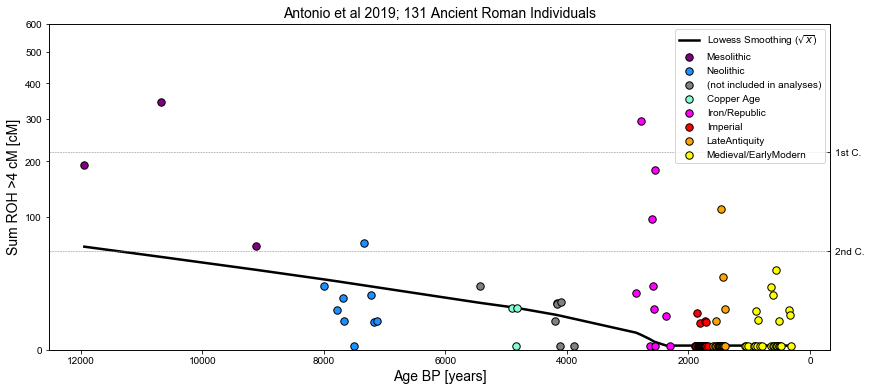

In [106]:
df1 = pd.read_csv("./Empirical/1240k/Antonio/combined_roh05.csv", sep="\t")
df1 = pre_process_roman_df(df1, age_error=100)
plot_lowess_smoothing(df1, cm=4, ylim=[0,600], title=f"Antonio et al 2019; {len(df1)} Ancient Roman Individuals",
                      lowess=True, frac=0.8, figsize=(14,6), s=55, savepath="./figures/manuscript/supplement/timelines/antonio.pdf")

# Plot Regions of Europe

### Do the Plot for Iberia

Found 43 Individuals; 27 from Geography


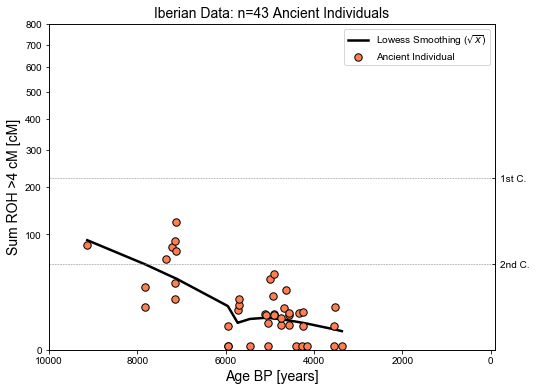

In [113]:
df_e = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_e["color"]="coral"
df_e["clst"]="Ancient Individual"
df_e = extract_df_age(df_e,0,15000)
df_e = extract_sub_df_geo_kw(df_e,  35.95, 44, -10, 4, keywords=["Iberia", "Portugal", "Spain"])
plot_lowess_smoothing(df_e, cm=4, xlim=[-100, 10000], ylim=[0,800], title=f"Iberian Data: n={len(df_e)} Ancient Individuals",
                      lowess=True, frac=0.8, figsize=(8,6), s=55, savepath="")

### Do the Plot for UK

Found 114 Individuals; 113 from Geography


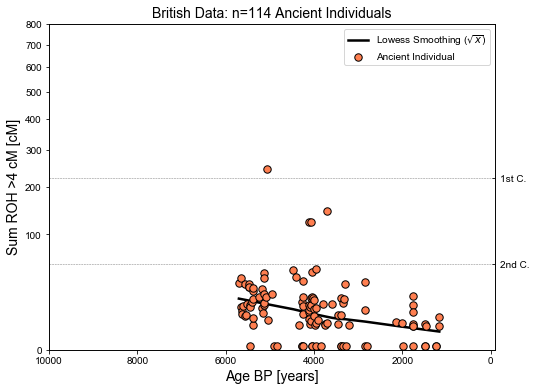

In [120]:
df_e = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_e["color"]="coral"
df_e["clst"]="Ancient Individual"
df_e = extract_df_age(df_e,0,20000)
df_e = extract_sub_df_geo_kw(df_e, 49, 60, -12, 3, keywords=["UK", "Britain", "British", "Scotland", "Engand"])

plot_lowess_smoothing(df_e, cm=4, xlim=[-100,10000], ylim=[0,800], title=f"British Data: n={len(df_e)} Ancient Individuals",
                      lowess=True, frac=0.8, figsize=(8,6), s=55, savepath="")

# Do the Plot for South America

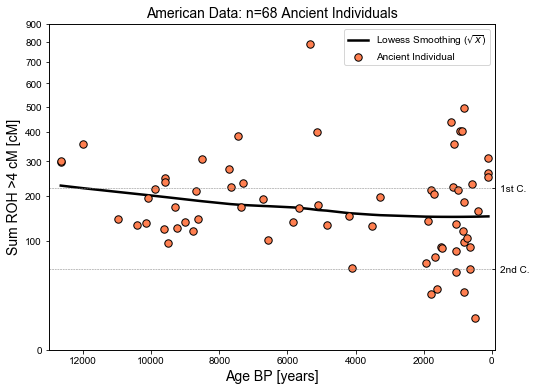

In [57]:
df_e = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_e["color"] = "coral"
df_e["clst"] = "Ancient Individual"
df_a = extract_df_geo(df_e, -60, 55, -130, -30).copy()  # Make a new Copy. America

plot_lowess_smoothing(df_a, cm=4, xlim=[-100,13000], ylim=[0,900], title=f"American Data: n={len(df_a)} Ancient Individuals",
                      lowess=True, frac=0.8, figsize=(8,6), s=55, savepath="")

# Plot European Data

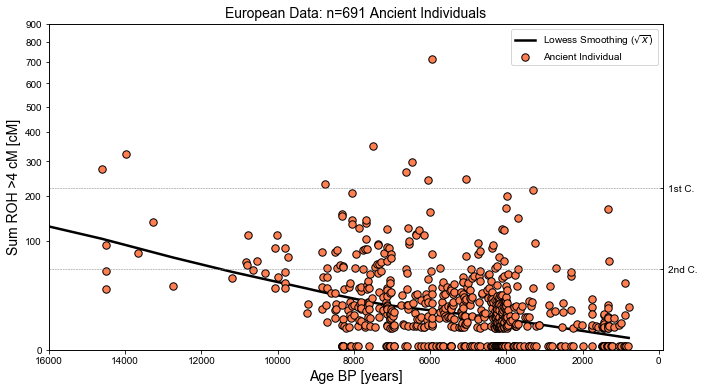

In [58]:
df_e = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_e["color"]="coral"
df_e["clst"]="Ancient Individual"
df_euro = extract_df_geo(df_e, 29, 62, -10, 45).copy()  # Make a new Copy. EUrope

plot_lowess_smoothing(df_euro, cm=4, xlim=[-100,16000], ylim=[0,900], 
                      title=f"European Data: n={len(df_euro)} Ancient Individuals",
                      lowess=True, frac=0.8, figsize=(11,6), s=55, savepath="")

# Load Sardinia anaysis

Found 40 Individuals; 40 from Geography


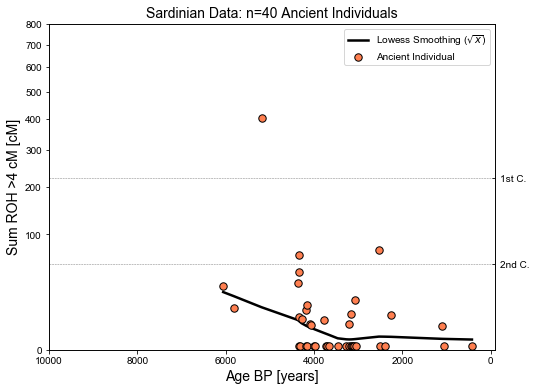

In [136]:
df_e = pd.read_csv("./Empirical/1240k/MarcusAncs/combined_roh05.csv", sep="\t")
df_e["color"]="coral"
df_e["clst"]="Ancient Individual"
df_e = extract_df_age(df_e,0,20000)
df_e = extract_sub_df_geo_kw(df_e, 38.7, 41.3, 8.0, 9.9, keywords=["Sar-"])

plot_lowess_smoothing(df_e, cm=4, xlim=[-100,10000], ylim=[0,800], title=f"Sardinian Data: n={len(df_e)} Ancient Individuals",
                      lowess=True, frac=0.8, figsize=(8,6), s=55, savepath="")

### Area 51